결측치와 전처리 모두 진행했음 모델링 진행할 차례
<br>데이터 분석대회에서 가장 많이 사용하는 머신러닝 모델인
<br>RandomForest와 XGBoost를 비교분석 + optuna로 하이퍼파라미터 튜닝

In [2]:
!nvidia-smi

Fri Feb 28 07:35:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def processing(train, test):
  # Train과 Test 불러오고 합치기
  x = train.drop(['ID','허위매물여부'],axis=1)
  y = train['허위매물여부']
  x_test = test.drop(['ID'],axis=1)

  label_encode_cols = ['제공플랫폼', '방향','중개사무소','게재일']

  for col in label_encode_cols:
    le = LabelEncoder()
    # Train 데이터에서 LabelEncoder 학습
    x[col] = le.fit_transform(x[col].astype(str))
    #  새로운 값 예외 처리 (Test 데이터에서 Train에 없는 값은 -1로 변환)
    x_test[col] = x_test[col].astype(str).apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

  # One-Hot Encoding 적용 열
  one_hot_cols = ['매물확인방식', '주차가능여부']
  # One-Hot Encoding 적용
  one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  # Train 데이터 변환
  x_encoded = one_hot_encoder.fit_transform(x[one_hot_cols])
  x_test_encoded = one_hot_encoder.transform(x_test[one_hot_cols])

  x_encoded_df = pd.DataFrame(x_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=x.index)
  x_test_encoded_df =  pd.DataFrame(x_test_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=x_test.index)
  # 기존 데이터와 병합
  x = pd.concat([x.drop(columns=one_hot_cols), x_encoded_df], axis=1)
  x_test = pd.concat([x_test.drop(columns=one_hot_cols), x_test_encoded_df], axis=1)
  return x ,y, x_test

In [4]:
from sklearn.experimental import enable_iterative_imputer  # MICE 사용을 위해 필요
from sklearn.impute import IterativeImputer  # 이제 import 가능
from sklearn.ensemble import RandomForestRegressor

# 결측치 impute
def impute(train,test):
  train_column = train.columns
  test_column = test.columns
  missing_columns = ['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']

  # 📌 3. MICE Imputation 적용 (Train 데이터로 학습 후, Test 데이터에 적용)
  mice_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42), max_iter=10)

  # 결측치 넣기
  train_data_imputed = pd.DataFrame(mice_imputer.fit_transform(train), columns=train_column)
  test_data_imputed = pd.DataFrame(mice_imputer.transform(test), columns=test_column)

  return train_data_imputed, test_data_imputed

In [5]:
import pandas as pd
# X_train X_test 선언
data = pd.read_csv('/content/drive/MyDrive/부동산실습/train.csv')
test = pd.read_csv('/content/drive/MyDrive/부동산실습/test.csv')
data = data[data['관리비'] != 96]
data = data[data['총주차대수']!=590]
X_train , y_train , X_test = processing(data, test)
X_train, X_test = impute(X_train , X_test)

In [6]:
# train에서 없는 test셋의 새로운 데이터
for col in X_test.columns:
  print('-------columns name :{}-----------'.format(col))
  print(len(X_test[X_test[col] == -1]))

-------columns name :보증금-----------
0
-------columns name :월세-----------
0
-------columns name :전용면적-----------
0
-------columns name :해당층-----------
0
-------columns name :총층-----------
0
-------columns name :방향-----------
0
-------columns name :방수-----------
0
-------columns name :욕실수-----------
0
-------columns name :총주차대수-----------
0
-------columns name :관리비-----------
0
-------columns name :중개사무소-----------
20
-------columns name :제공플랫폼-----------
1
-------columns name :게재일-----------
22
-------columns name :매물확인방식_서류확인-----------
0
-------columns name :매물확인방식_전화확인-----------
0
-------columns name :매물확인방식_현장확인-----------
0
-------columns name :주차가능여부_가능-----------
0
-------columns name :주차가능여부_불가능-----------
0


In [7]:
import optuna
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# F1-score를 최적화 지표로 사용
f1_scorer = make_scorer(f1_score)

# 목표 함수 정의
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.5, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 2.0, 10.0)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        scale_pos_weight=scale_pos_weight,
        device='cuda',
        tree_method="hist",
        eval_metric="logloss",
        random_state=42
    )


    # 교차 검증 (F1-score 기준)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer).mean()
    return score  # F1-score 최대화

In [8]:
# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# 최적 class_weight 찾기
print("Best parameters:", study.best_params)

model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

[I 2025-02-28 07:36:16,451] A new study created in memory with name: no-name-158d81c4-f0e9-4d40-9027-b322d81355db
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:36:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2025-02-28 07:36:19,633] Trial 0 finished with value: 0.8592706014845064 and parameters: {'n_estimators': 611, 'max_depth': 5, 'learning_rate': 0.1399733369742118, 'subsample': 0.9780334619359965, 'colsample_bytree': 0.6357280922812395, 'gamma': 1.5338953243129239, 'min_child_weight': 6, 'scale_pos_weight': 8.152409607643683}

Best parameters: {'n_estimators': 205, 'max_depth': 9, 'learning_rate': 0.12230625978543726, 'subsample': 0.8910787931723028, 'colsample_bytree': 0.7122512418099873, 'gamma': 2.1812461118706206, 'min_child_weight': 10, 'scale_pos_weight': 2.1013062414375048}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:37:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7122512418099873, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.1812461118706206, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12230625978543726,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=205, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
def pred(model, X_test, name):
  pred = pd.Series(model.predict(X_test))
  print(sum(pred))
  submit = pd.read_csv('/content/drive/MyDrive/부동산실습/sample_submission.csv')
  submit['허위매물여부'] = pred
  submit.to_csv( '/content/drive/MyDrive/부동산실습/'+name+'.csv', index = False)

In [10]:
pred(model, X_test, "XGboost")

62


<ipython-input-11-c0dba7e9e3ea>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")


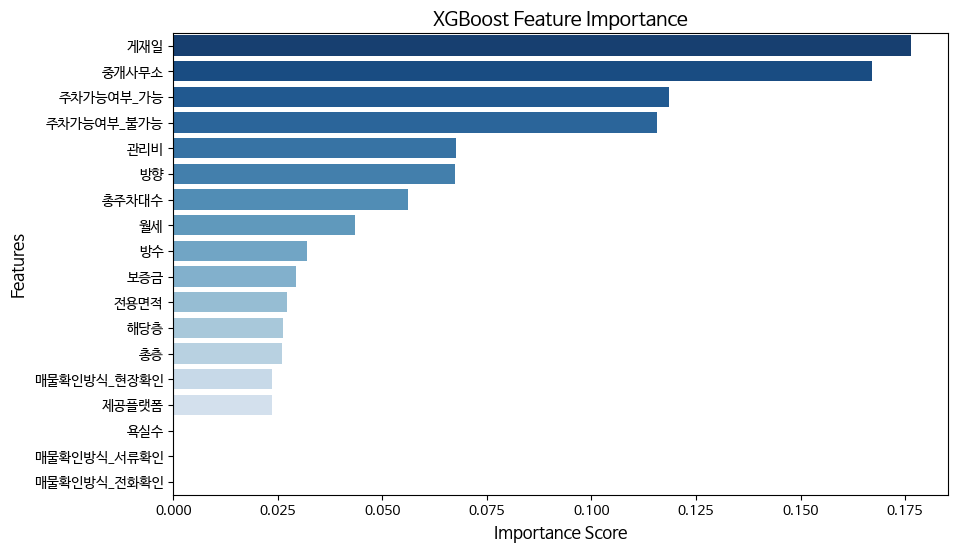

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='NanumBarunGothic')
# feature importance 시각화
# 📌 2️⃣ Feature Importance 추출
feature_importance = model.feature_importances_

# 📌 3️⃣ 데이터 프레임 변환 (시각화를 위해)
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)  # 중요도 순 정렬

# 📌 4️⃣ Feature Importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")
plt.title("XGBoost Feature Importance", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

In [22]:
import numpy as np
import pandas as pd
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score

def objective_2(trial, X, y):
    # 하이퍼파라미터 탐색 범위 설정
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])  # Removed 'auto'
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])

    # 모델 생성
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        random_state=42
    )

    # 5-Fold Cross Validation을 사용하여 f1_score 평가
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro')
    return np.mean(f1_scores)

In [23]:
# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_2(trial, X_train, y_train), n_trials=20)

# 최적 class_weight 찾기
print("Best parameters:", study.best_params)

# 최적화된 모델 생성 및 학습
best_params = study.best_params
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)  # 모델 학습

[I 2025-02-28 07:46:22,777] A new study created in memory with name: no-name-837bb0ff-cab1-4151-8d08-3e72eb246bc4
[I 2025-02-28 07:46:25,522] Trial 0 finished with value: 0.8717236231682659 and parameters: {'n_estimators': 187, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.8717236231682659.
[I 2025-02-28 07:46:30,036] Trial 1 finished with value: 0.8481007531128645 and parameters: {'n_estimators': 335, 'max_depth': 48, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.8717236231682659.
[I 2025-02-28 07:46:39,741] Trial 2 finished with value: 0.8800807256776914 and parameters: {'n_estimators': 482, 'max_depth': 31, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8800807256776914.
[I 2025-02-28 07:46:41,608] Trial 3 finished with 

Best parameters: {'n_estimators': 491, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced'}


RandomForestClassifier(class_weight='balanced', max_depth=50,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=491, random_state=42)

In [24]:
pred(model, X_test, "RandomForest")

60


<ipython-input-25-c0dba7e9e3ea>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")


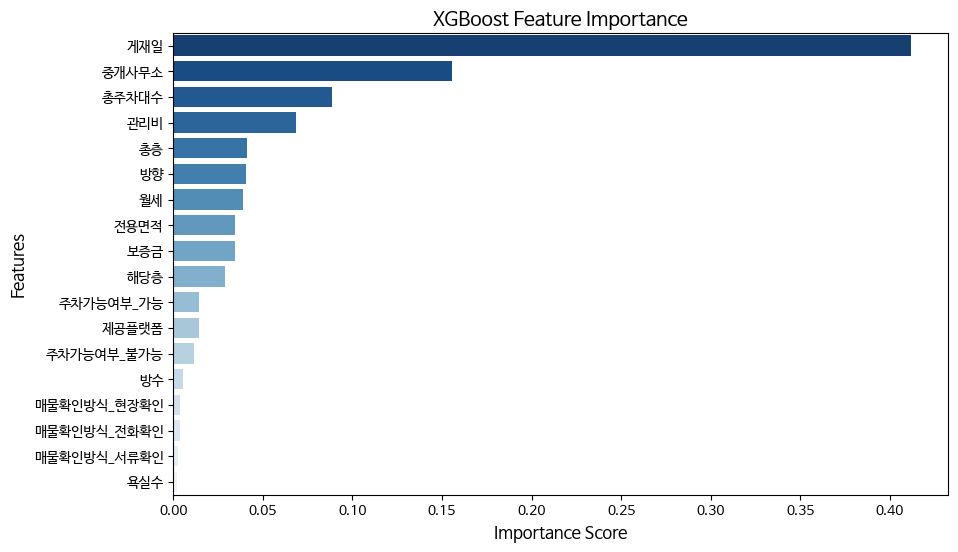

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='NanumBarunGothic')
# feature importance 시각화
# 📌 2️⃣ Feature Importance 추출
feature_importance = model.feature_importances_

# 📌 3️⃣ 데이터 프레임 변환 (시각화를 위해)
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)  # 중요도 순 정렬

# 📌 4️⃣ Feature Importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")
plt.title("XGBoost Feature Importance", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()